# Etivity 5: _Regression and Dimensionality Reduction_
**Student Name**: _Sean Morrissey_

**Student ID**: _17222761_

The aim of this etivity is to introduce dimensionality reduction into the process of training and comparing predictive models. In this etivity multiple regression models will be trained and evaluated on the insurance dataset along with the implementation of dimensionality reduction to the training pipeline. In this etivity we will:
- Perform **EDA** and **Data Preparation** on the dataset
- Introduce **Dimensionality Reduction** into the training pipeline through **PCA** and **RFE**
- Also perform **LinearDiscriminantAnalysis**, **FeatureAgglomeration** and **NeighborhoodComponentsAnalysis** dimensionality reduction 
- Train and evaluate **Linear Regression** and **Random Forest Regressor** models
- Also train and evaluate an **SVR** model
- Explore the optimal parameters for each model
- Produce metrics for each model such as **MSE**, **MAE** and **R2** and evaluate each model based on these metrics

## Part 1: Imports

In [137]:
# Import required packages

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn import cluster
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Part 2: Exploratory Data Analysis

Exploratory data analysis is completed to check for missing values and outliers.

In [138]:
# Read in the dataset
df = pd.read_csv("./insurance-1.csv")

# Check the data from the first five rows of the dataframe
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [139]:
# Check the data from the last five rows of the dataframe
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [140]:
df['insurance_cost'].value_counts()

1639.56310     2
8825.08600     1
4837.58230     1
3172.01800     1
12646.20700    1
              ..
2719.27975     1
19539.24300    1
12269.68865    1
6117.49450     1
10959.33000    1
Name: insurance_cost, Length: 1337, dtype: int64

In the above cell we check the different values in our target column `insurance_cost` and the amount of instances for each of the separate values. We can see that there is a total of 1337 unique values in `insurance_cost` with only one `insurance_cost` having a count greater than one.

In [141]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

A check for missing values shows that there is no missing values in the dataset for any of the columns.

In [142]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


A brief view of the statistics of the numerical attributes all of the attributes look ok.

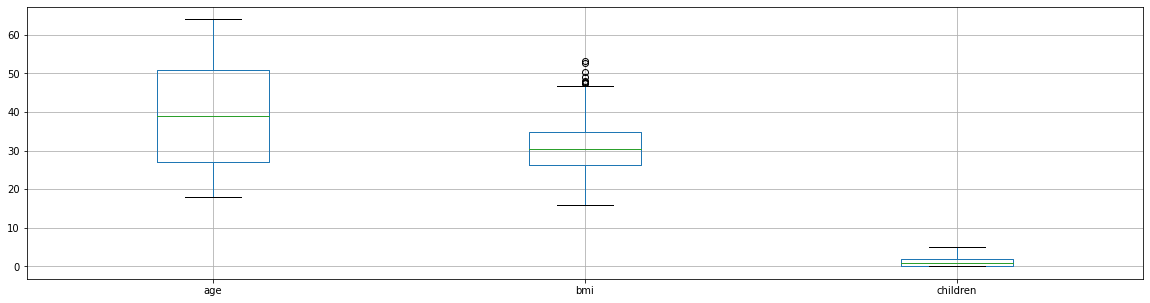

In [143]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

Box plots of the numerical attributes shows that the attribute `bmi` contains some outliers. The attributes `children` and `age` contain no outliers.

The reason for not including `insurance_cost` in this box plot is due to the size and range of values it includes and would distort the view of the other attributes.

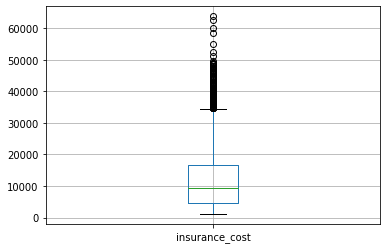

In [144]:
df.boxplot(column=['insurance_cost'])
plt.show()

A box plot of the `insurance_cost` attribute shows that it contains a high amount of outliers.

We will apply a **RobustScaler** to the attribute `bmi` as it contains outliers and we will apply a **StandardScaler** to the other attributes as they contain no outliers. We will not apply any scaler to the `insurance_cost` attribute as it will be used as the target attribute for regression in this notebook.

## Part 3: Data Preparation

In [145]:
df = pd.get_dummies(df, columns=['region', 'gender', 'smoker'], 
                        #dummy_na=True, 
                        drop_first=True)

In the above cell we apply **One hot encoding** to the categorical columns `region`, `gender` and `smoker` as these categorical features are not Ordinal. The result of this **one hot encoding** is multiple numerical columns.

In [146]:
# Check the data from the first five rows of the dataframe after one hot encoding
df.head()

,age,bmi,children,insurance_cost,region_northwest,region_southeast,region_southwest,gender_male,smoker_yes
0,18,33.770,1,1725.55230,0,1,0,1,0
1,18,34.100,0,1137.01100,0,1,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [147]:
# Check the data from the last five rows of the dataframe after one hot encoding
df.tail()

,age,bmi,children,insurance_cost,region_northwest,region_southeast,region_southwest,gender_male,smoker_yes
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,1,0,0,0,1
1335,64,26.410,0,14394.55790,0,0,0,1,0
1336,64,36.960,2,49577.66240,0,1,0,1,1
1337,64,23.760,0,26926.51440,0,1,0,1,1


All of the categorical data has now been transformed to numerical data.

In [148]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

We create two lists:
- The first list contains the columns which contain outliers
- The second list contains the columns without outliers

For the columns with outliers we will apply the **RobustScaler** and a log function, for the columns without outliers we will apply the **StandardScaler**.

In [149]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

The above class is created for use in the preprocessing pipeline to put the names of the columns back together after they have been split into training and test datasets. We need this as we need to apply preperation strategies to the two groups of columns.

In [150]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

The above class simply selects a group of columns.

In [151]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

We create our preprocess pipeline which applies the StandardScaler to the columns with no outliers and applies the log and RobustScaler to the columns with outliers. It then Unions the two together.

In [152]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

We split the target attribute which is `insurance_cost` away from the rest of the predictors. 

Then we split both the x and y dataframes into **test** and **training** sets. The training sets contains **80%** of the data while the test sets contain the remaining **20%**. We also shuffle the dataset but we use stratify so that the test and training sets remain proportionate.

## Part 4: Dimensionality Reduction & Grid Search for Best Parameters

Next we train our `RandomForestRegressor`, `LinearRegression` and `SVR` models on the training set with a range of possible parameters in order to find th best parameters by cross-validation. To do this we use a pipeline which includes the preprocessing pipeline to scale our attributes and each model respectably. Dimensionality reduction is also included into the pipeline after the preprocessing is complete. Five various dimensionality reduction methods were implemented into the process as part of this etivity. Grid search will pick the best dimensionality reduction method for use as well as the parameters. These dimensionality reduction methods are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`
- Feature Agglomeration
- Linear Discriminant Analysis
- Neighborhood Components Analysis

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

#### Random Forest Pipeline

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [153]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In the above cell we create the pipeline for our **preprocessing**, **dimensionality reduction** and **model training**.

In [154]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.857:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


The above output shows the **cross validation** score for the `RandomForestRegressor` model and the best parameters for the model.

It also shows that the best **dimensionality reduction** method for `LinearRegression` was Recursive Feature Elimination (RFE) with estimator `LinearRegression`

The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

#### Linear Regression Pipeline

**Linear Regression** fits a linear model with coefficients to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [155]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In the above cell we create the pipeline for our **preprocessing**, **dimensionality reduction** and **model training**.

In [156]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.752:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__normalize': False}


The above output shows the **cross validation** score for the `LinearRegression` model and the best parameters for the model.

It also shows that the best **dimensionality reduction** method for `LinearRegression` was Recursive Feature Elimination (RFE) with estimator `svm.SVR`

#### SVR Pipeline

**Support vector regression (SVR)** is characterized by the use of kernels, sparse solution, and VC control of the margin and the number of support vectors. **SVR** has been proven to be an effective tool in real-value function estimation.

In [157]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR())])

In the above cell we create the pipeline for our **preprocessing**, **dimensionality reduction** and **model training**.

In [158]:
N_FEATURES_OPTIONS = [2, 6, 11]
DEGREE = [1, 2, 3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__degree': DEGREE,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__degree': DEGREE,
    },
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'regresson__degree': DEGREE,
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__degree': DEGREE,
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__degree': DEGREE,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = -0.095:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'regresson__degree': 1}


The above output shows the **cross validation** score for the `SVR` model and the best parameters for the model.

It also shows that the best **dimensionality reduction** method for `SVR` was Recursive Feature Elimination (RFE) with estimator `svm.SVR`

## Part 5: Comparison and Evaluation of Regression Models

In [159]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

The above method is used for evaluating the best models found by the grid search on the test dataset and compare their metrics. The method takes in a model as well as the _x_test_ and _y_test_ and returns:

- The Mean Squared Error (MSE)
- The Mean Absolute Error (MAE)
- 1 Relative Squared Error (R2)

These metrics will then be used to choose which regression model is the best for the problem domain.

In [160]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

We use the above function to compute the **MSE**, **MAE**, and **R2** for each of the best models (**Linear Regression**, **Random Forest Regressor** and **SVR**) produced by the grid search.

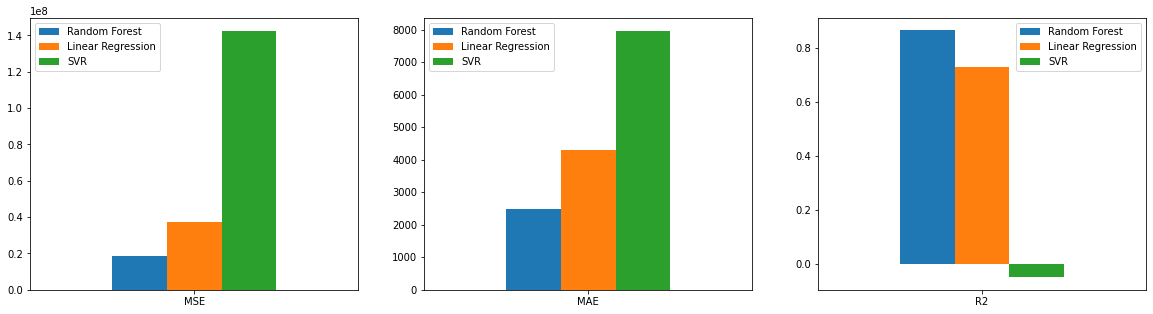

In [161]:
# Create Pandas Barplots
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2 than the other two models. The MSE and MAE values tell us how far apart our predicted values are from the actual values, with a higher MSE and MAE meaning that the model is worse. The R2 score is however different as it tells about the goodness of fit of a model and so the higher the R2 the better the model. For these reasons the **Random Forest Regressor** can be seen as the best of the 3 models.

The second best performing model was **Linear Regression** which had an MSE and MAE roughly 2x bigger than **Random Forest Regressor** and an R2 score slightly lower than **Random Forest Regressor**.

The worst performing model of the 3 models was by far **SVR** which achieved an MSE roughly 7x bigger than **Random Forest Regressor** and 3.5x bigger than **Linear Regression**. **SVR** also had the highest MAE of the three models which was roughly 4x bigger than **Random Forest Regressor** and 2x bigger than **Linear Regression**. Where **SVR** performs the worst is in its R2 score, achieving a negative R2 score meaning that the model is arbitrarily worse.

However, the **Linear Regression** and **SVR** both perform comparatibly, achieving the same scores for MSE, MAE and R2 as can be seen in the 3 plots above.

## Part 6: Train a Final Model

In [162]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Finally, we can train an Random Forest Regressor model with all data we have, assuming that the more data we have the better the model.

In [163]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

We can also store this model on disk.